In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import cv2
import numpy as np


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import glob
import sklearn.metrics
import seaborn as sns
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd "/content/drive/MyDrive/oct"
!unzip -qq "/content/drive/MyDrive/oct/OCT_small.zip"

replace OCT_small/test/CNV/CNV-6554931-1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
total_dir = "/content/OCT_small"
train_dir = "/content/OCT_small/train"
test_dir = "/content/OCT_small/test"

In [ ]:
classes = os.listdir(train_dir)
print(classes)

['DME', 'NORMAL', 'CNV', 'DRUSEN']


In [ ]:
dataset = {
    "img_path" : [], 
    "class" : [], 
    "split" : []
}

for split in os.listdir(total_dir):
  for where in os.listdir(total_dir + "/" + split):
    for image in glob.glob(total_dir+"/"+split+"/"+where+"/*.jpeg"):
      dataset["img_path"].append(image)
      dataset["class"].append(where)
      dataset["split"].append(split)

dataset = pd.DataFrame(dataset)
dataset.head()

,img_path,class,split
0,/content/OCT_small/test/DME/DME-9931747-3.jpeg,DME,test
1,/content/OCT_small/test/DME/DME-3358004-19.jpeg,DME,test
2,/content/OCT_small/test/DME/DME-3606968-15.jpeg,DME,test
3,/content/OCT_small/test/DME/DME-7757895-2.jpeg,DME,test
4,/content/OCT_small/test/DME/DME-7949765-2.jpeg,DME,test


In [ ]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
valid_df = dataset[dataset["split"] == "validation"]

print(test_df.head(10))

                                          img_path class split
0   /content/OCT_small/test/DME/DME-9931747-3.jpeg   DME  test
1  /content/OCT_small/test/DME/DME-3358004-19.jpeg   DME  test
2  /content/OCT_small/test/DME/DME-3606968-15.jpeg   DME  test
3   /content/OCT_small/test/DME/DME-7757895-2.jpeg   DME  test
4   /content/OCT_small/test/DME/DME-7949765-2.jpeg   DME  test
5  /content/OCT_small/test/DME/DME-8699233-19.jpeg   DME  test
6   /content/OCT_small/test/DME/DME-3546221-1.jpeg   DME  test
7   /content/OCT_small/test/DME/DME-8123126-5.jpeg   DME  test
8   /content/OCT_small/test/DME/DME-3347866-4.jpeg   DME  test
9   /content/OCT_small/test/DME/DME-1805818-5.jpeg   DME  test


In [ ]:
len(train_df), len(test_df), len(valid_df)

(4995, 1425, 709)

Text(0.5, 1.0, 'Validation Dataset')

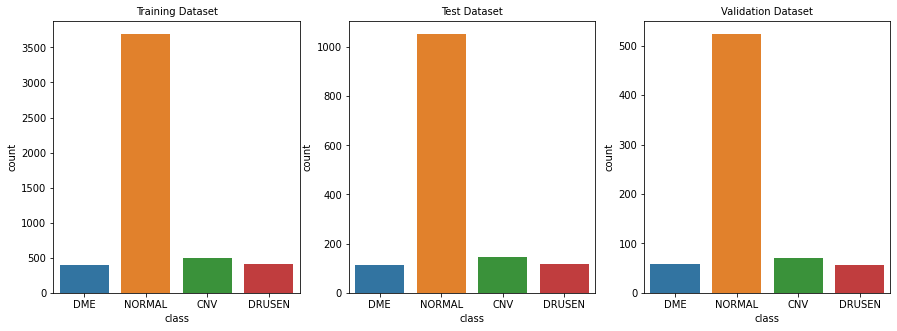

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["class"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=valid_df["class"])
plt.title("Validation Dataset", size=10)

In [ ]:
X_train = train_df["img_path"]
y_train = train_df["class"]

X_test = test_df["img_path"]
y_test = test_df["class"]

X_val = valid_df["img_path"]
y_val = valid_df["class"]


In [ ]:
for name in list(train_df["class"].unique()):
  print(name, len(train_df[train_df["class"] == name]))


DME 396
NORMAL 3692
CNV 497
DRUSEN 410


In [ ]:
for name in list(test_df["class"].unique()):
  print(name, len(test_df[test_df["class"] == name]))


DME 112
NORMAL 1053
CNV 144
DRUSEN 116


In [ ]:
for name in list(valid_df["class"].unique()):
  print(name, len(valid_df[valid_df["class"] == name]))


DME 58
NORMAL 524
CNV 71
DRUSEN 56


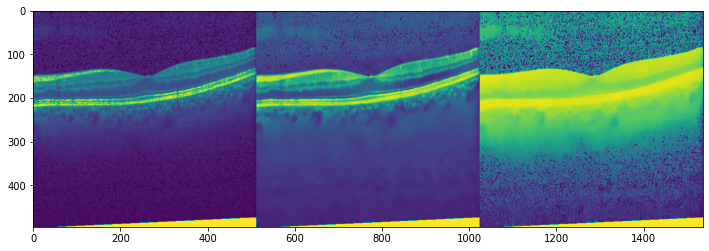

In [ ]:

sample = random.choice(dataset["img_path"])
#image = mpimg.imread(sample)
img = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
hist1 = cv2.calcHist(img, [0], None, [256], [0, 256])
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(img)
he = cv2.equalizeHist(img)

img2 = cv2.fastNlMeansDenoising(cl, None, 16, 7,21)
img3 = cv2.fastNlMeansDenoising(he, None, 16, 7,21)
res = np.hstack((img,img2, img3)) #stacking images side-by-side

plt.figure(figsize=(12, 5))
plt.imshow(res)
plt.show()

In [ ]:
def norm_digit(img):
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32)
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

In [ ]:
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.transform import resize

def img_preprocess(imgs):
  images = []
  bar_total = tqdm(imgs)
  for file in bar_total:
          
          img = cv2.imread(file, 0)
          img = np.where(img == 255, 0, img)
          img = norm_digit(img)
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          #cl1 = cv2.fastNlMeansDenoising(img, None, 12, 7,21)
          cl1 = clahe.apply(img)
          
        
          images.append(resize(cl1, (128,128,3)))
          
  images = np.array(images)
  return images

In [ ]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)
X_val = img_preprocess(X_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded

In [ ]:
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_val = makelabel(y_val)

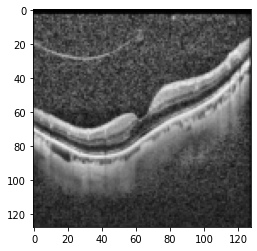

In [ ]:

plt.imshow(X_train[random.choice(range(len(X_train)))])

In [ ]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(images,labels_encoded, test_size=0.2, random_state=13, stratify=labels_encoded)
#X_train.shape, X_test.shape

In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(128, 128, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=X_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(4, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(4, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], 
              loss_weights=[1, 0.3, 0.3], metrics=['accuracy'], 
              )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        resizing[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, [y_train, y_train, y_train], 
                    validation_data=(X_test, [y_test, y_test, y_test]), batch_size=32, epochs=1000, 
                    callbacks=[early_stopping, mc])

Epoch 1/1000
157/157 [==============================] - 30s 74ms/step - loss: 1.4267 - dense_4_loss: 0.8898 - dense_1_loss: 0.8896 - dense_3_loss: 0.9001 - dense_4_accuracy: 0.7369 - dense_1_accuracy: 0.7371 - dense_3_accuracy: 0.7373 - val_loss: 1.3636 - val_dense_4_loss: 0.8535 - val_dense_1_loss: 0.8465 - val_dense_3_loss: 0.8541 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.7389 - val_dense_3_accuracy: 0.7389
Epoch 2/1000
157/157 [==============================] - 10s 65ms/step - loss: 1.3583 - dense_4_loss: 0.8485 - dense_1_loss: 0.8455 - dense_3_loss: 0.8537 - dense_4_accuracy: 0.7391 - dense_1_accuracy: 0.7393 - dense_3_accuracy: 0.7389 - val_loss: 1.3777 - val_dense_4_loss: 0.8896 - val_dense_1_loss: 0.7927 - val_dense_3_loss: 0.8344 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.7389 - val_dense_3_accuracy: 0.7389
Epoch 3/1000
157/157 [==============================] - 10s 64ms/step - loss: 1.2207 - dense_4_loss: 0.7712 - dense_1_loss: 0.7400 - dense_3_los

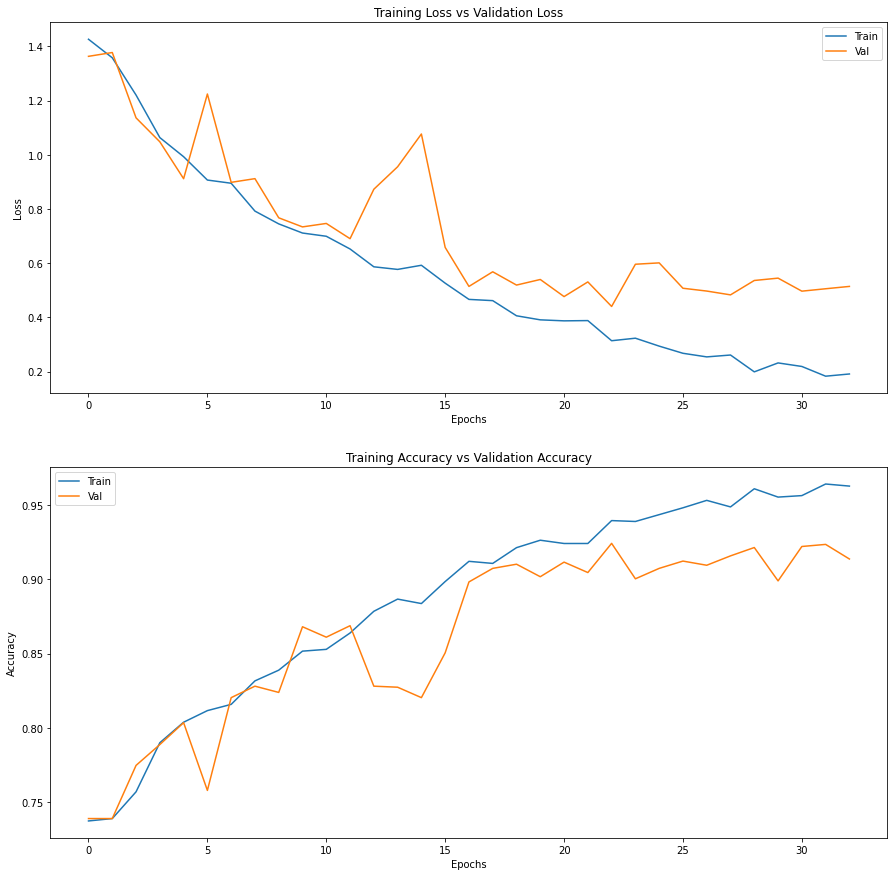

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_3_accuracy'])
axs[1].plot(history.history['val_dense_3_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 1s 21ms/step - loss: 0.5144 - dense_4_loss: 0.3283 - dense_1_loss: 0.3139 - dense_3_loss: 0.3066 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.9102 - dense_3_accuracy: 0.9137


[0.514402449131012,
 0.32825136184692383,
 0.31394362449645996,
 0.3065602779388428,
 0.9024561643600464,
 0.9101754426956177,
 0.9136841893196106]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

pred = model.predict(X_val)
pred = np.argmax(pred[0], axis=1)
accuracy_score(y_val, pred)

accuracy_score(y_val, pred), confusion_matrix(y_val, pred)

(0.921015514809591, array([[ 62,   0,   8,   1],
        [  8,  40,   1,   9],
        [  2,   0,  38,  16],
        [  1,   0,  10, 513]]))